In [4]:
import duckdb
import time
import os
import fiona
from shapely.geometry import shape
import requests, io
import pandas as pd
from zipfile import ZipFile
import geopandas as gpd
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [84]:
# sql ggplot
from sql.ggplot import ggplot, aes, geom_boxplot, geom_histogram, facet_wrap

In [90]:
# conn = duckdb.connect(database=':memory:')
tempdir = r'C:\Users\nross\OneDrive - Government of BC\Documents\BRFNDocs\work-test'
db = os.path.join(tempdir,'vri_analysis.db')
sql_ducdb = 'duckdb://'
conn = duckdb.connect(database=db)
conn.install_extension("httpfs")
conn.install_extension("spatial")
conn.load_extension("httpfs")
conn.load_extension("spatial")
vri_url = "https://nrs.objectstore.gov.bc.ca/rczimv/geotest/veg_comp_layer_r1_poly.parquet"
aoi_path = r'\\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\WMB_Study_Area_2024_07_30\WMB_Study_Area_2024_07_30.shp'
aflb_gdb = r'\\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\BRFNLupce.gdb'

In [91]:
# Setup sql magic and show current tables
%sql conn --alias duckdb
%sql select * from information_schema.tables

Running query in 'duckdb'

table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action,TABLE_COMMENT
vri_analysis,main,aflb,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,midaspen,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,pspl,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,rplots,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,species,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,vri,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,vri_pspl_species,BASE TABLE,None,None,None,None,None,YES,NO,None,None


In [19]:
# read AOI as shapely geom
with fiona.open(aoi_path) as shapefile:
    aoi = shape(shapefile[0]['geometry'])

<h1>PSPL data</h1>

1. Use the <a href="https://catalogue.data.gov.bc.ca/dataset/fadm-timber-supply-area-tsa">TSA layer</a> or <a href = "https://governmentofbc.maps.arcgis.com/apps/webappviewer/index.html?id=7bb2cbccb9be4f0aa808f1858b399980">PSPL Locator App</a> to find out which TSAs your AOI is in.

2. Change TSA_number_list (below) to use the numbers (string with leading zero for single-digit numbers) of the TSAs that overlap your AOI. 

    For example, since my AOI was in Fort St. John and Fort Nelson TSAs, I entered '08' and '40'

3. This section will retrieve the PSPL data from your AOI, convert to GDF, then save as a table in your duckdb

In [ ]:
# merge and clip PSPL data as gdf
TSA_number_list = ['08', '40']
baseUrl = "https://www.for.gov.bc.ca/ftp/HTS/external/!publish/Provincial_Site_Productivity_Layer/Site_Prod_for_DMF"

pspl_gdf = []

# Loop over TSA
for tsa in TSA_number_list:
    t_time = time.time()
    pspl_url = os.path.join(baseUrl, f'sprod_{tsa}.gdb.zip')
    r = requests.get(pspl_url)
    with ZipFile(io.BytesIO(r.content)) as z:
        z.extractall(tempdir)
    gdf = gpd.read_file(f"{tempdir}\\sprod_{tsa}.gdb", layer=f'sprod_{tsa}', bbox=aoi)
    gdf = gdf.loc[gdf.intersects(aoi)]
    pspl_gdf.append(gdf)
    print(f"TSA {tsa} downloaded and clipped in {round(time.time() - t_time,1)} seconds")
    
pspl_gdf = pd.concat(pspl_gdf)
try:
    os.remove(os.path.join(os.getcwd, 'temp'))
except:
    print(f"Could not delete temp folder {os.path.join(os.getcwd, 'temp')}")

# save gdf in duckdb
# gdf_duck['geometry'] = gdf_duck['geometry'].apply(lambda geom: geom.wkb)
conn.sql('DROP TABLE IF EXISTS pspl;')
conn.execute("CREATE TABLE pspl AS SELECT ST_GeomFromWKB(geometry) as geom, * EXCLUDE (geometry) FROM pspl_gdf;")

TSA 08 downloaded and clipped in 847.7 seconds
TSA 40 downloaded and clipped in 1669.9 seconds


C:\Users\nross\AppData\Local\Temp\ipykernel_51816\3789762987.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pspl_gdf = pd.concat(pspl_gdf)


PermissionError: [WinError 5] Access is denied: 'temp'

In [14]:
# Get list of species to analyze
species_df = conn.sql("select distinct SPECIES_CD_1[:2] as species, count(species_cd_1) as polygon_count, sum(polygon_area) as area_ha from vri group by species_cd_1").to_df()

# Optional: to merge species into ones not given in PSPL, assign them in this dictionary and uncomment the following line
# This is best done after inspecting the results of this cell
species_map = {
    "S": "SW", # for example, if there are polygons called "S" (undifferentiated) in the VRI, I will assume these are "SW" (white spruce) for the purpose of productivity estimates
    "P": "PL", # Undifferentiated Pine assumed to be lodgepole (P. contorta)
    "AC": "AT" # Cottonwood (Populus sp) assumed to be the same as trembling aspen
}

species_df['PSPL_spc'] = species_df['species']
species_df['PSPL_spc'] = species_df['PSPL_spc'].replace(species_map)
species_df = species_df.groupby(by=['species', 'PSPL_spc']).sum()
species_df.reset_index(inplace=True)

pspl_species = conn.sql("select column_name as x from information_schema.columns where table_name = 'pspl' and column_name[-3:] = '_SI';").to_df()
pspl_species = pspl_species['x'].str.slice(0, 2).to_list()


species_df.loc[species_df['species'].isin(pspl_species), 'In PSPL'] = True
species_df.loc[~species_df['species'].isin(pspl_species), 'In PSPL'] = False

species_df

C:\Users\nross\AppData\Local\Temp\ipykernel_49628\1928513661.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  species_df.loc[species_df['species'].isin(pspl_species), 'In PSPL'] = True


,species,PSPL_spc,polygon_count,area_ha,In PSPL
0,AC,AT,2278,18382.630417,False
1,AT,AT,39688,472666.563952,True
2,BL,BL,498,5438.227869,True
3,EP,EP,3860,47125.084069,True
4,LT,LT,1527,22396.959237,True
5,P,PL,1,28.250029,False
6,PL,PL,27945,329455.892647,True
7,S,SX,108,1134.440804,False
8,SB,SB,67072,837939.834930,True
9,SE,SE,8,29.164410,True


Any species with "False" for "In PSPL" will not be assigned a PSPL value. These stands are dominated by a species not listed in the PSPL layer, likely because it is a generic or non-commercial species. Use the species_map dictionary above to reassign these to another species if desired.

See the <a href="https://www2.gov.bc.ca/gov/content/industry/forestry/managing-our-forest-resources/tree-seed/tree-seed-centre/seed-testing/codes">BC Tree Species Codes</a> table to identify.

The "Spruce Substitution" methods from <a href="https://bcgov.github.io/FAIB_PSPL/#run-the-spruce-substitution">FAIB_PSPL</a>'s methods could be used to remove the SX values which don't have a good site index value.

<i>Sx = Se where BEC = ‘ESSF’

Ss = Sx where BEC is coastal (CDF, CWH, MH)

Sx = Sw where BEC != ‘ESSF’ and BEC is not coastal</i>

In [61]:
for spc_no in range(1, 7):
  spc_no = str(spc_no)
  
  # check if column exists
  result = conn.execute(f"""
    SELECT COUNT(*) AS column_exists
    FROM information_schema.columns
    WHERE table_name = 'vri' AND column_name = 'PSPL_SPC{spc_no}';
  """).fetchone()
  if result[0] == 0:
    conn.execute(f"ALTER TABLE vri ADD COLUMN PSPL_SPC{spc_no} VARCHAR;")
  else:
    conn.execute(f"ALTER TABLE vri DROP COLUMN PSPL_SPC{spc_no};")
    conn.execute(f"ALTER TABLE vri ADD COLUMN PSPL_SPC{spc_no} VARCHAR;")
  # Hybrid Spruce Substitution:
  conn.sql(f"""
    UPDATE VRI
    SET PSPL_SPC{spc_no} = (
      IF (SPECIES_CD_{spc_no} IS NULL, NULL, 
        IF (
          SPECIES_CD_{spc_no}[:2] NOT IN ('SX', 'AC', 'P', 'S'),
          SPECIES_CD_{spc_no},
          IF (SPECIES_CD_{spc_no} == 'AC',
              'AT',
              IF (
                SPECIES_CD_{spc_no} == 'P',
                'PL',
                IF (
                  SPECIES_CD_{spc_no} == 'S',
                  'SW',
                  IF (
                    BEC_ZONE_CODE == 'ESSF',
                    'SE',
                    IF(
                      BEC_ZONE_CODE IN ('CDF', 'CWH', 'MH'),
                      'SS',
                      'SW'
                      )
                    )
                  )
                )
              )
          )
        ) 
    )
    """)

In [64]:
%sql select columns(c -> c LIKE 'PSPL_SPC%'), columns(c -> c LIKE 'SPECIES_CD%') from vri

Running query in 'duckdb'

PSPL_SPC1,PSPL_SPC2,PSPL_SPC3,PSPL_SPC4,PSPL_SPC5,PSPL_SPC6,SPECIES_CD_1,SPECIES_CD_2,SPECIES_CD_3,SPECIES_CD_4,SPECIES_CD_5,SPECIES_CD_6
SB,PL,AT,None,None,None,SB,PL,AT,None,None,None
AT,SB,SW,None,None,None,AT,SB,SX,None,None,None
AT,SW,AT,None,None,None,AT,SX,AC,None,None,None
PL,SB,None,None,None,None,PL,SB,None,None,None,None
SB,PL,None,None,None,None,SB,PL,None,None,None,None
SW,PL,AT,SB,None,None,SW,PL,AT,SB,None,None
PL,None,None,None,None,None,PL,None,None,None,None,None
AT,SB,PL,None,None,None,AT,SB,PL,None,None,None
None,None,None,None,None,None,None,None,None,None,None,None
None,None,None,None,None,None,None,None,None,None,None,None


<h2>Join VRI polygons with PSPL</h2>

This loops over all 6 species and gets PSPL averages for all of them. We ended up only looking at the leading species so this is unnessecary, but I left it in just in case someone else needs it. You could remove the first loop (for spc_no in range(1,6)).

In [67]:
for spc_no in range(1, 7):
  count=0
  spc_no = str(spc_no)
  
  # check if column exists
  result = conn.execute(f"""
    SELECT COUNT(*) AS column_exists
    FROM information_schema.columns
    WHERE table_name = 'vri' AND column_name = 'PSPL_SI_SPC{spc_no}';
  """).fetchone()
  if result[0] == 0:
    conn.execute(f"ALTER TABLE vri ADD COLUMN PSPL_SI_SPC{spc_no} DOUBLE;")
  
  print(f"\n###########################\nSPECIES {spc_no}")
    
  for species in species_df.loc[species_df['In PSPL'], 'species']:
    count+=1
    print(f"Calculating {species} ({count}/{len(species_df.loc[species_df['In PSPL']])})")
    s_time = time.time()
    average_pspl = f"""
    -- First, perform a spatial join to sum the values of the points that fall within each polygon
    WITH pspl_avg AS (
      SELECT
        v.OBJECTID,
        AVG(p.{species}_SI) AS PSPL_SI_SPC{spc_no}
      FROM
        vri v, pspl p
      WHERE
        ST_Contains(v.geom, p.geom) and v.PSPL_SPC{spc_no}[:2] = '{species}'
      GROUP BY
        v.OBJECTID
    )

    -- Update the vri table by joining with the aggregated values
    UPDATE vri
    SET PSPL_SI_SPC{spc_no} = pspl_avg.PSPL_SI_SPC{spc_no}
      FROM pspl_avg
      WHERE pspl_avg.OBJECTID = vri.OBJECTID
        AND  vri.PSPL_SPC{spc_no}[:2] = '{species}'
    ;
    """
    x = conn.sql(average_pspl)
    # r = conn.sql(f"select PSPL_SI_SPC{spc_no} from vri where vri.PSPL_SPC[:2] = '{species}'")
    # print(r)
    print(f"{species} done in {round(time.time() - s_time,1)}s.\n")


###########################
SPECIES 1
Calculating AT (1/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

AT done in 3.8s.

Calculating BL (2/10)
BL done in 0.5s.

Calculating EP (3/10)
EP done in 1.0s.

Calculating LT (4/10)
LT done in 0.9s.

Calculating PL (5/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

PL done in 2.7s.

Calculating SB (6/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SB done in 5.7s.

Calculating SE (7/10)
SE done in 0.5s.

Calculating SS (8/10)
SS done in 0.4s.

Calculating SW (9/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SW done in 3.1s.

Calculating SX (10/10)
SX done in 0.4s.


###########################
SPECIES 2
Calculating AT (1/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

AT done in 3.7s.

Calculating BL (2/10)
BL done in 0.8s.

Calculating EP (3/10)
EP done in 1.3s.

Calculating LT (4/10)
LT done in 1.7s.

Calculating PL (5/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

PL done in 3.2s.

Calculating SB (6/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SB done in 2.6s.

Calculating SE (7/10)
SE done in 0.5s.

Calculating SS (8/10)
SS done in 0.5s.

Calculating SW (9/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SW done in 3.3s.

Calculating SX (10/10)
SX done in 0.4s.


###########################
SPECIES 3
Calculating AT (1/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

AT done in 2.8s.

Calculating BL (2/10)
BL done in 0.7s.

Calculating EP (3/10)
EP done in 1.4s.

Calculating LT (4/10)
LT done in 1.1s.

Calculating PL (5/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

PL done in 2.1s.

Calculating SB (6/10)
SB done in 1.7s.

Calculating SE (7/10)
SE done in 0.5s.

Calculating SS (8/10)
SS done in 0.4s.

Calculating SW (9/10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SW done in 2.4s.

Calculating SX (10/10)
SX done in 0.4s.


###########################
SPECIES 4
Calculating AT (1/10)
AT done in 1.5s.

Calculating BL (2/10)
BL done in 0.6s.

Calculating EP (3/10)
EP done in 1.1s.

Calculating LT (4/10)
LT done in 0.7s.

Calculating PL (5/10)
PL done in 1.1s.

Calculating SB (6/10)
SB done in 1.0s.

Calculating SE (7/10)
SE done in 0.5s.

Calculating SS (8/10)
SS done in 0.4s.

Calculating SW (9/10)
SW done in 1.1s.

Calculating SX (10/10)
SX done in 0.4s.


###########################
SPECIES 5
Calculating AT (1/10)
AT done in 0.8s.

Calculating BL (2/10)
BL done in 0.6s.

Calculating EP (3/10)
EP done in 0.8s.

Calculating LT (4/10)
LT done in 0.7s.

Calculating PL (5/10)
PL done in 0.7s.

Calculating SB (6/10)
SB done in 0.7s.

Calculating SE (7/10)
SE done in 0.5s.

Calculating SS (8/10)
SS done in 0.4s.

Calculating SW (9/10)
SW done in 0.7s.

Calculating SX (10/10)
SX done in 0.5s.


###########################
SPECIES 6
Calculating AT (1/10)


Calculate PSPL weighted average, coalescing to avoid null values and adjusting them to reach approx. 100%. This approach is incorrect as Site Index is based on species specific curves and a conversion value needs to be applied when combining them. Just using species 1 is most appropriate. I've still included this code in case it's useful for someone else attempting a similar problem in the future, or the conversion values from FAIB could be added here. Contact Gordon Nienaber or FAIB for more info.

In [ ]:
# create columns if not exist
result = conn.execute(f"""
    SELECT COUNT(*) AS column_exists
    FROM information_schema.columns
    WHERE table_name = 'vri' AND column_name = 'PSPL_SI_avg';
""").fetchone()
if result[0] == 0:
  conn.execute(f"ALTER TABLE vri ADD COLUMN PSPL_SI_avg DOUBLE;")

result = conn.execute(f"""
    SELECT COUNT(*) AS column_exists
    FROM information_schema.columns
    WHERE table_name = 'vri' AND column_name = 'PSPL_SI_wavg';
""").fetchone()
if result[0] == 0:
  conn.execute(f"ALTER TABLE vri ADD COLUMN PSPL_SI_wavg DOUBLE;")

In [ ]:
%%sql
# Getting average and weighted average PSPL across species - note that this is an incorrect approach as site index is species-specific and corrections must be made to convert between them
# According to Gordon Nienaber from FAIB, using the value for species 1 is most appropriate
UPDATE vri

SET PSPL_SI_avg =
    (SELECT AVG(c)
        from (VALUES(PSPL_SI_SPC1), (PSPL_SI_SPC2), (PSPL_SI_SPC3), (PSPL_SI_SPC4), (PSPL_SI_SPC5), (PSPL_SI_SPC6)) T (c));

# weighted average
UPDATE vri
SET PSPL_SI_wavg = 
    COALESCE(
        PSPL_SI_SPC1 * species_pct_1/100 + PSPL_SI_SPC2 * species_pct_2/100 + PSPL_SI_SPC3 * species_pct_3/100 + PSPL_SI_SPC4 * species_pct_4/100 + PSPL_SI_SPC5 * species_pct_5/100 + PSPL_SI_SPC6 * species_pct_6/100,
        (PSPL_SI_SPC1 * species_pct_1/100 + PSPL_SI_SPC2 * species_pct_2/100 + PSPL_SI_SPC3 * species_pct_3/100 + PSPL_SI_SPC4 * species_pct_4/100 + PSPL_SI_SPC5 * species_pct_5/100) / (species_pct_1/100 + species_pct_2/100 + species_pct_3/100 + species_pct_4/100 + species_pct_5/100),
        (PSPL_SI_SPC1 * species_pct_1/100 + PSPL_SI_SPC2 * species_pct_2/100 + PSPL_SI_SPC3 * species_pct_3/100 + PSPL_SI_SPC4 * species_pct_4/100) / (species_pct_1/100 + species_pct_2/100 + species_pct_3/100 + species_pct_4/100),
        (PSPL_SI_SPC1 * species_pct_1/100 + PSPL_SI_SPC2 * species_pct_2/100 + PSPL_SI_SPC3 * species_pct_3/100) / (species_pct_1/100 + species_pct_2/100 + species_pct_3/100),
        (PSPL_SI_SPC1 * species_pct_1/100 + PSPL_SI_SPC2 * species_pct_2/100) / (species_pct_1/100 + species_pct_2/100),
        PSPL_SI_SPC1
    )

Running query in 'duckdb'

Count
188049


In [82]:
%%sql
select  AVG(PSPL_SI_SPC1), AVG(SITE_INDEX), count(PSPL_SI_SPC1), sum(POLYGON_AREA) from vri WHERE SPECIES_CD_1[:2] = 'SX';

Running query in 'duckdb'

avg(PSPL_SI_SPC1),avg(SITE_INDEX),count(PSPL_SI_SPC1),sum(POLYGON_AREA)
19.98815585118097,15.424597757548886,9082,96932.78146008043


In [80]:
%%sql
select 'VRI Site Index' as " ",
    count(site_index) as "count",
    sum(POLYGON_AREA) as "area",
    avg(site_index) as "Mean",
    max(site_index) as "Max",
    stddev(site_index) as "Std Dev",

from vri where SITE_INDEX is not null
    
union ALL

select 'PSPL Sp1 Site Index',
    count(PSPL_SI_SPC1) as "count",
    sum(POLYGON_AREA) as "area",
    avg(PSPL_SI_SPC1),
    max(PSPL_SI_SPC1),
    stddev(PSPL_SI_SPC1)
    from vri where PSPL_SI_SPC1 is not null

Running query in 'duckdb'

,count,area,Mean,Max,Std Dev
VRI Site Index,174891,2048166.4073131639,11.58913095293461,34.0,5.106190104939095
PSPL Sp1 Site Index,147824,1780515.1740653405,14.710847237114853,22.41999969482422,4.203220536923251


In [107]:
%%sql # aspen
select 'VRI Site Index aspen' as " ",
    count(site_index) as "count",
    avg(site_index) as "Mean",
    max(site_index) as "Max",
    stddev(site_index) as "Std Dev"

from vri WHERE SPECIES_CD_1 LIKE 'A%'
    
union ALL

select 'PSPL Site Index aspen',
    count(PSPL_SI_SPC1) as "count",
    avg(PSPL_SI_SPC1),
    max(PSPL_SI_SPC1),
    stddev(PSPL_SI_SPC1)
    from vri WHERE SPECIES_CD_1 LIKE 'A%'

Running query in 'duckdb'

,count,Mean,Max,Std Dev
VRI Site Index aspen,41958,16.016180507169278,32.900001525878906,3.02129619545249
PSPL Site Index aspen,40547,17.200459552866366,20.700000762939453,0.9199046964742471


In [114]:
%sql select distinct SPECIES_CD_1, SUM(POLYGON_AREA) from VRI where PSPL_SI_SPC1 IS NOT NULL GROUP BY SPECIES_CD_1

Running query in 'duckdb'

SPECIES_CD_1,sum(POLYGON_AREA)
BL,512.632988981561
SB,827037.482520366
AT,470214.2775353435
ACB,29.347811238931662
SX,95418.76268922552
AC,17757.88589162478
S,1043.4835319318838
ACT,237.87816257538518
SW,168741.1255322658
PL,172429.39637587202


In [118]:
%%sql
drop table if exists midaspen;
create table midaspen as
SELECT PSPL_SI_SPC1,
    SITE_INDEX,
    SITE_INDEX - PSPL_SI_SPC1 as SI_diff,
    SPECIES_CD_1[:2] as SPECIES_CD_1,
    COALESCE(SPECIES_CD_2[:2], '.None') as SPECIES_CD_2,
    POLYGON_AREA
FROM vri
WHERE SPECIES_CD_1 LIKE 'A%'
AND SITE_INDEX <= 18
AND SITE_INDEX > 14
AND CAST(PROJ_AGE_CLASS_CD_1 AS INT) > 5 -- i.e. leading species > 100 years old;

drop table if exists vri_pspl_species;
create table vri_pspl_species as
SELECT PSPL_SI_SPC1, SITE_INDEX,
    SPECIES_CD_1[:2] as SPECIES_CD_1,
    COALESCE(SPECIES_CD_2[:2], '.None') as SPECIES_CD_2,
    POLYGON_AREA
FROM vri
WHERE SPECIES_CD_1[:2] IN ('AT', 'AC', 'SB', 'SW', 'PL', 'SX')

Running query in 'duckdb'

Count
168959


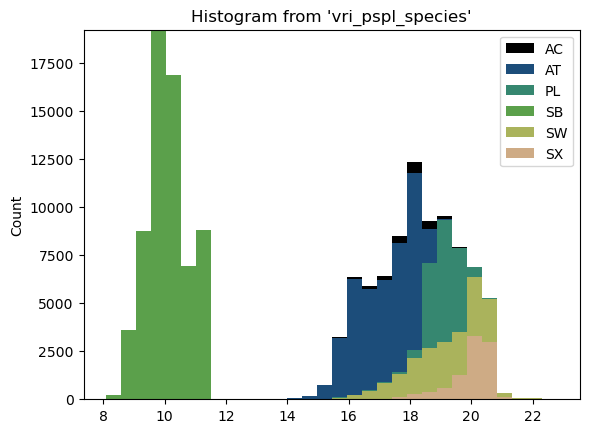

In [119]:
(ggplot("vri_pspl_species", aes(x="PSPL_SI_SPC1")) + geom_histogram(bins=30, fill="SPECIES_CD_1[:2]", cmap='gist_earth_r'))

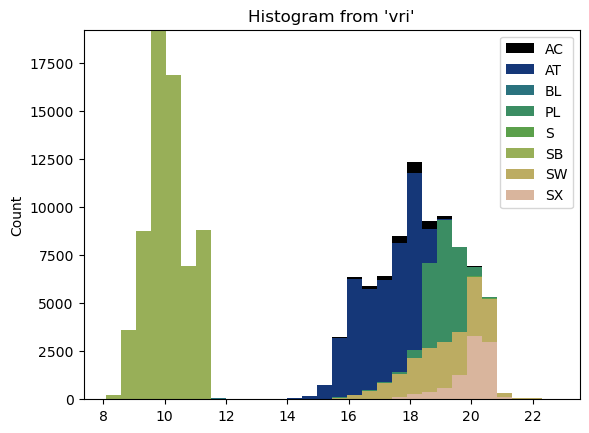

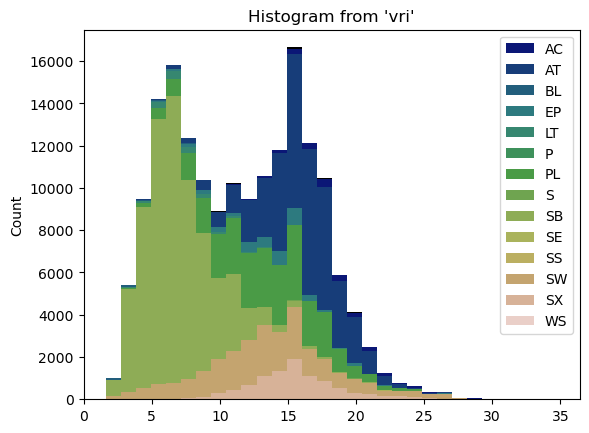

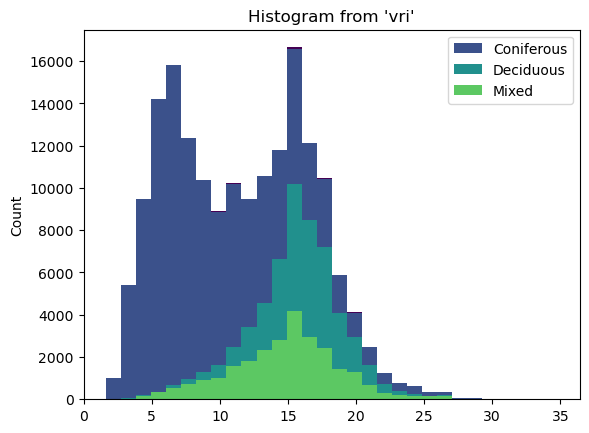

In [95]:
(ggplot("vri", aes(x="PSPL_SI_SPC1")) + geom_histogram(bins=30, fill="SPECIES_CD_1[:2]", cmap='gist_earth_r'))
(ggplot("vri", aes(x="SITE_INDEX")) + geom_histogram(bins=30, fill="SPECIES_CD_1[:2]", cmap='gist_earth_r'))
(ggplot("vri", aes(x="SITE_INDEX")) + geom_histogram(bins=30, fill="STAND_TYPE_25", cmap='viridis_r'))

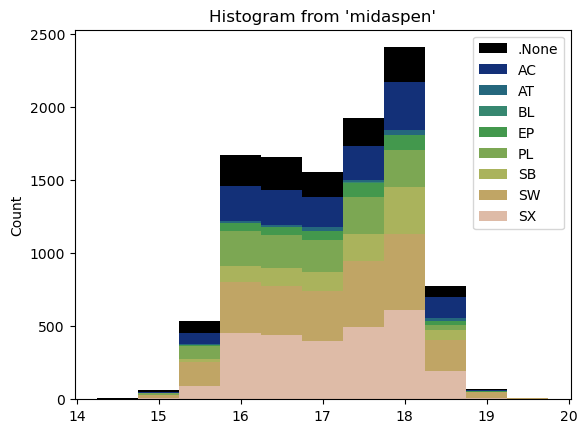

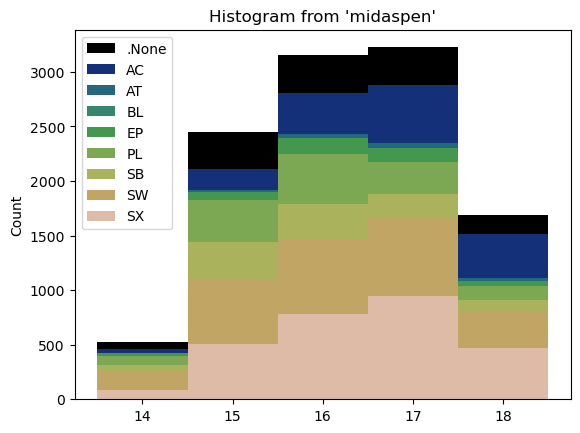

In [110]:
(ggplot("midaspen", aes(x="PSPL_SI_SPC1")) + geom_histogram(binwidth=0.5, fill="SPECIES_CD_2", cmap='gist_earth_r'))
(ggplot("midaspen", aes(x="SITE_INDEX")) + geom_histogram(binwidth=1, fill="SPECIES_CD_2", cmap='gist_earth_r'))

Text(0.5, 0, 'VRI minus PSPL Site Index (m)')

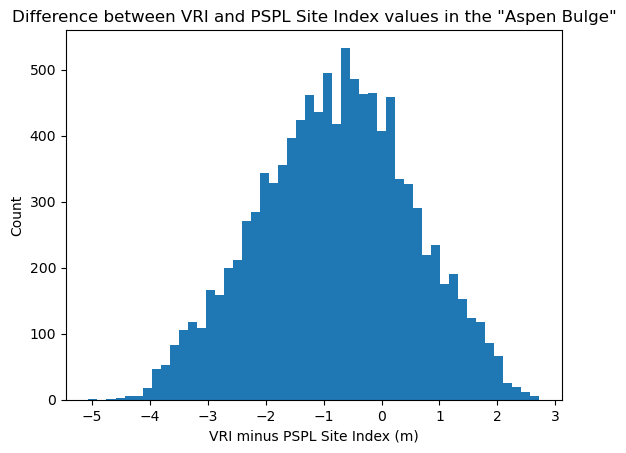

In [105]:
ax = %sqlplot histogram --table midaspen --column SI_diff
ax.set_title("Difference between VRI and PSPL Site Index values in the \"Aspen Bulge\"")
ax.set_xlabel("VRI minus PSPL Site Index (m)")

Text(0, 0.5, 'Site Productivity (m height at 50bha)')

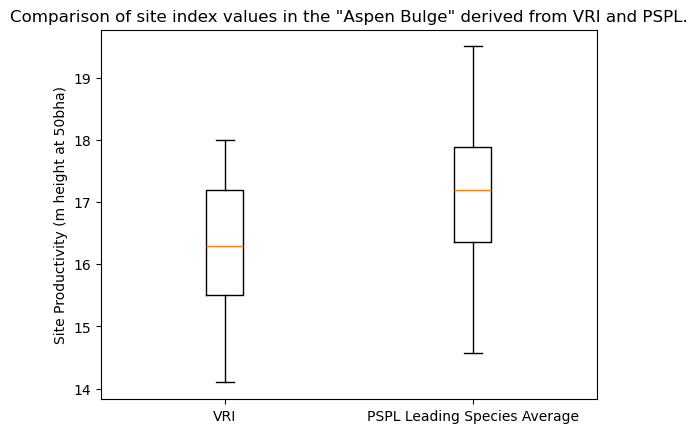

In [106]:
ax = %sqlplot boxplot --table midaspen --column SITE_INDEX PSPL_SI_SPC1
ax.set_title("Comparison of site index values in the \"Aspen Bulge\" derived from VRI and PSPL.")
ax.set_xticklabels(['VRI', 'PSPL Leading Species Average'])
ax.set_ylabel("Site Productivity (m height at 50bha)")


In [89]:
conn.close()